#  DeepTesla

## 数据处理

In [5]:
import cv2
import pandas as pd
import numpy as np
## Load wheel signal data
df = pd.read_csv('./epochs/epoch01_steering.csv')
## Show
df.head()

,ts_micro,frame,wheel
0,1464650070285914,0,-1.0
1,1464650070319247,1,-1.0
2,1464650070352581,2,-1.0
3,1464650070385914,3,-1.0
4,1464650070419247,4,-1.0


In [6]:
import cv2
import imageio
import pandas as pd
import numpy as np
epoch_ids = [i+1 for i in range(10)]
img_data=[[] for i in range(10)]
label_data=[[] for i in range(10)]

for epoch_id in epoch_ids:
    print('---------- processing video {} ----------'.format(epoch_id))
    csv_path =  'epochs/epoch{:0>2}_steering.csv'.format(epoch_id)
    df = pd.read_csv(csv_path)
    label_data[epoch_id-1] = df['wheel'].values
    mkv_path =  'epochs/epoch{:0>2}_front.mkv'.format(epoch_id)
    vid = imageio.get_reader(mkv_path, 'ffmpeg')
    for i in range(len(df)):
        img = cv2.resize(vid.get_data(i),(224,224))
        img_data[epoch_id-1].append(img)
    print('end of video {},'.format(epoch_id),
          'img_count:',len(img_data[epoch_id-1]),'img_shape:',img_data[epoch_id-1][0].shape,'labels:',label_data[epoch_id-1].shape)

img_data = np.concatenate(img_data, axis=0)
label_data = np.concatenate(label_data, axis=0)
print('-------------end of all---------------','\nimg_data:',img_data.shape,'label_data:',label_data.shape)

---------- processing video 1 ----------
end of video 1, img_count: 1500 img_shape: (224, 224, 3) labels: (1500,)
---------- processing video 2 ----------
end of video 2, img_count: 3900 img_shape: (224, 224, 3) labels: (3900,)
---------- processing video 3 ----------
end of video 3, img_count: 2700 img_shape: (224, 224, 3) labels: (2700,)
---------- processing video 4 ----------
end of video 4, img_count: 2700 img_shape: (224, 224, 3) labels: (2700,)
---------- processing video 5 ----------
end of video 5, img_count: 2700 img_shape: (224, 224, 3) labels: (2700,)
---------- processing video 6 ----------
end of video 6, img_count: 2700 img_shape: (224, 224, 3) labels: (2700,)
---------- processing video 7 ----------
end of video 7, img_count: 2700 img_shape: (224, 224, 3) labels: (2700,)
---------- processing video 8 ----------
end of video 8, img_count: 2700 img_shape: (224, 224, 3) labels: (2700,)
---------- processing video 9 ----------
end of video 9, img_count: 2700 img_shape: (224

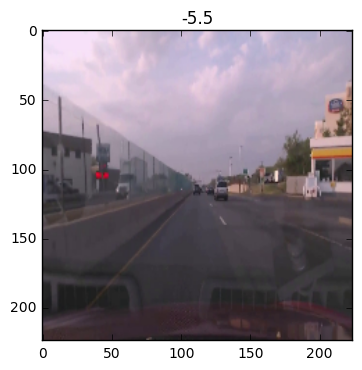

In [8]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
index = random.randint(0,len(img_data))
plt.title(label_data[index])
plt.imshow(img_data[index])

In [9]:
##shuffle
p = np.random.permutation(len(img_data))
img_data,label_data = img_data[p],label_data[p]
##split
index = int(len(img_data)*0.8)
train_image,test_image = img_data[:index], img_data[index:]
train_label,test_label = label_data[:index], label_data[index:]
print(train_image.shape,test_image.shape)
print(train_label.shape,test_label.shape)

(21600, 224, 224, 3) (5400, 224, 224, 3)
(21600,) (5400,)


In [12]:
from keras.models import Model
from keras.optimizers import SGD,RMSprop
from keras.callbacks import TensorBoard
from keras.layers import Input, Flatten, Dropout,Dense,Reshape,Convolution2D, MaxPooling2D,GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet',include_top=False)

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.7)(x)
output = Dense(1)(x)
model = Model(input=base_model.input,output=output)

for layer in base_model.layers:
    layer.trainable = False

opt = RMSprop(lr=1e-6)
model.compile(optimizer='Adadelta',
              loss='mse')

model.fit(train_image,train_label,validation_split=0.2,batch_size=32, callbacks=[TensorBoard(log_dir='./log')])
model.evaluate(test_image, test_label)

model.save('./models/model.h5')
with open('./models/model.json', 'w') as f:
    f.write(model.to_json())

Train on 17280 samples, validate on 4320 samples
Epoch 1/10
17280/17280 [==============================] - 364s - loss: 10.7838 - val_loss: 5.0530
Epoch 2/10
17280/17280 [==============================] - 355s - loss: 4.2462 - val_loss: 2.3550
Epoch 3/10
17280/17280 [==============================] - 356s - loss: 2.9345 - val_loss: 2.6779
Epoch 4/10
17280/17280 [==============================] - 356s - loss: 2.2289 - val_loss: 1.8053
Epoch 5/10
17280/17280 [==============================] - 356s - loss: 1.8992 - val_loss: 1.5202
Epoch 6/10
17280/17280 [==============================] - 356s - loss: 1.6615 - val_loss: 1.5304
Epoch 7/10
17280/17280 [==============================] - 356s - loss: 1.4962 - val_loss: 0.9993
Epoch 8/10
17280/17280 [==============================] - 356s - loss: 1.3215 - val_loss: 1.0511
Epoch 9/10
17280/17280 [==============================] - 355s - loss: 1.2446 - val_loss: 1.8499
Epoch 10/10
5400/5400 [==============================] - 91s    


In [14]:
model.evaluate(test_image, test_label)

5400/5400 [==============================] - 88s    


0.7065757193388762

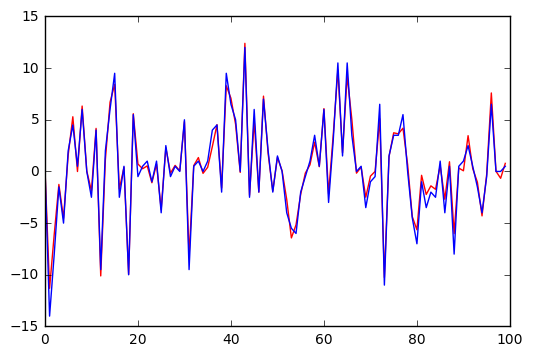

In [13]:
pred = model.predict(train_image[0:100])
plt.plot(pred,'r')
plt.plot(train_label[0:100],'b')
plt.show()

In [ ]:
import imageio
imageio.plugins.ffmpeg.download()

csv_path =  'epochs/epoch01_steering.csv'
df = pd.read_csv(csv_path)
label_data = df['wheel'].values
mkv_path =  'epochs/epoch01_front.mkv'
vid = imageio.get_reader(mkv_path, 'ffmpeg')
img_data = []
for i in range(len(df)):
    img = cv2.resize(vid.get_data(i),(224,224))
    img_data.append(img)
img_data = np.array(img_data)

Imageio: 'ffmpeg.win32.exe' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.win32.exe (27.4 MB)
Downloading: 8192/28781056 bytes (0.0%)16384/28781056 bytes (0.1%)32768/28781056 bytes (0.1%)40960/28781056 bytes (0.1%)57344/28781056 bytes (0.2%)73728/28781056 bytes (0.3%)90112/28781056 bytes (0.3%)122880/28781056 bytes (0.4%)139264/28781056 bytes (0.5%)155648/28781056 bytes (0.5%)172032/28781056 bytes (0.6%)188416/28781056 bytes (0.7%)204800/28781056 bytes (0.7%)221184/28781056 bytes (0.8%)237568/28781056 bytes (0.8%)

In [ ]:
from keras.models import load_model
model = lode_model('models/model.h5')
pred = model.predict(img_data[0:100])
plt.plot(pred,'r')
plt.plot(label_data[0:100],'b')
plt.show()